# Predicting Stock Price

The following sequence of code will prepare our data for analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(1)

## Collect and prepare data for analysis

In [3]:
df = pd.read_csv('./AAPL.csv',  parse_dates=True)

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df = df[['Close']] #the target column

In [6]:
df

,Close
0,162.880005
1,156.800003
2,156.570007
3,163.639999
4,157.649994
...,...
245,165.229996
246,166.470001
247,167.630005
248,166.649994


In [7]:
df['Close'].isna().sum()

0

In [8]:
row_count = df.shape[0] # store the number of observations
row_count

250

In [9]:
aapl = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of stock prices
aapl.shape

(250, 1)

In [10]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [11]:
aapl = aapl[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
aapl.shape

(250, 1)

In [12]:
aapl = aapl.reshape(row_count // sequence_length, sequence_length) # note that stock prices are a multiple of sequence length, we can split the data into rows of sequence length.
aapl

array([[162.880005, 156.800003, 156.570007, 163.639999, 157.649994,
        157.960007, 159.479996, 166.020004, 156.770004, 157.279999],
       [152.059998, 154.509995, 146.5     , 142.559998, 147.110001,
        145.539993, 149.240005, 140.820007, 137.350006, 137.589996],
       [143.110001, 140.360001, 140.520004, 143.779999, 149.639999,
        148.839996, 148.710007, 151.210007, 145.380005, 146.139999],
       [148.710007, 147.960007, 142.639999, 137.130005, 131.880005,
        132.759995, 135.429993, 130.059998, 131.559998, 135.869995],
       [135.350006, 138.270004, 141.660004, 141.660004, 137.440002,
        139.229996, 136.720001, 138.929993, 141.559998, 142.919998],
       [146.350006, 147.039993, 144.869995, 145.860001, 145.490005,
        148.470001, 150.169998, 147.070007, 151.      , 153.039993],
       [155.350006, 154.089996, 152.949997, 151.600006, 156.789993,
        157.350006, 162.509995, 161.509995, 160.009995, 166.130005],
       [165.809998, 165.350006, 164.86999

In [13]:
# create our X and y. 
# X will be the 9 days prior...
X = aapl[:, :-1] # all rows, all columns except the last one
# y will be the 10th day (what we are trying to predict)
y = aapl[:, -1] # all rows, only the last column

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(17, 9, 1)
(8, 9, 1)


**Single RNN**

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

In [17]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(32, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 11s 11s/step - loss: 22990.3516 - root_mean_squared_error: 151.6257 - val_loss: 20340.6133 - val_root_mean_squared_error: 142.6205
Epoch 2/600
1/1 [==============================] - 0s 231ms/step - loss: 22954.3418 - root_mean_squared_error: 151.5069 - val_loss: 20317.3867 - val_root_mean_squared_error: 142.5391
Epoch 3/600
1/1 [==============================] - 0s 215ms/step - loss: 22929.2266 - root_mean_squared_error: 151.4240 - val_loss: 20294.1250 - val_root_mean_squared_error: 142.4574
Epoch 4/600
1/1 [==============================] - 0s 120ms/step - loss: 22903.7422 - root_mean_squared_error: 151.3398 - val_loss: 20271.5742 - val_root_mean_squared_error: 142.3783
Epoch 5/600
1/1 [==============================] - 0s 138ms/step - loss: 22878.8320 - root_mean_squared_error: 151.2575 - val_loss: 20250.4668 - val_root_mean_squared_error: 142.3041
Epoch 6/600
1/1 [==============================] - 0s 146ms/step - loss: 22855.4570 - 

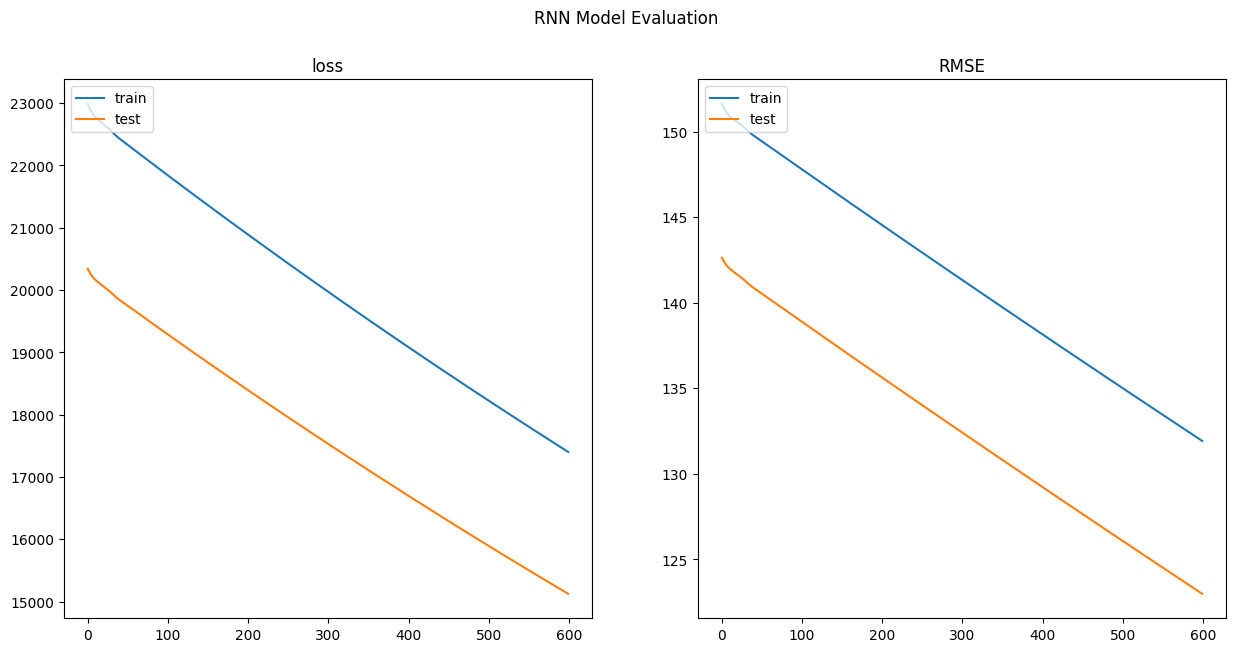

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [23]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  

mean_squared_error(y_test, y_pred)**0.5


1/1 [==============================] - 0s 117ms/step


122.98387053111612

**Deep RNN**

In [24]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(75, return_sequences=True, input_shape=[n_steps, n_inputs]),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(32, return_sequences=False),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 9, 75)             5775      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 9, 64)             8960      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,872
Trainable params: 17,872
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
1/1 [==============================] - 16s 16s/step - loss: 23079.8281 - root_mean_squared_error: 151.9205 - val_loss: 20296.4004 - val_root_mean_squared_error: 142.4654
Epoch 2/600
1/1 [==============================] - 0s 197ms/step - loss: 22906.7871 - root_mean_squared_error: 151.3499 - val_loss: 20160.7090 - val_root_mean_squared_error: 141.9884
Epoch 3/600
1/1 [==============================] - 0s 189ms/step - loss: 22761.6914 - root_mean_squared_error: 150.8698 - val_loss: 20035.8789 - val_root_mean_squared_error: 141.5482
Epoch 4/600
1/1 [==============================] - 0s 190ms/step - loss: 22628.0723 - root_mean_squared_error: 150.4263 - val_loss: 19916.3984 - val_root_mean_squared_error: 141.1255
Epoch 5/600
1/1 [==============================] - 0s 150ms/step - loss: 22500.2754 - root_mean_squared_error: 150.0009 - val_loss: 19793.2656 - val_root_mean_squared_error: 140.6885
Epoch 6/600
1/1 [==============================] - 0s 242ms/step - loss: 22368.9844 - 

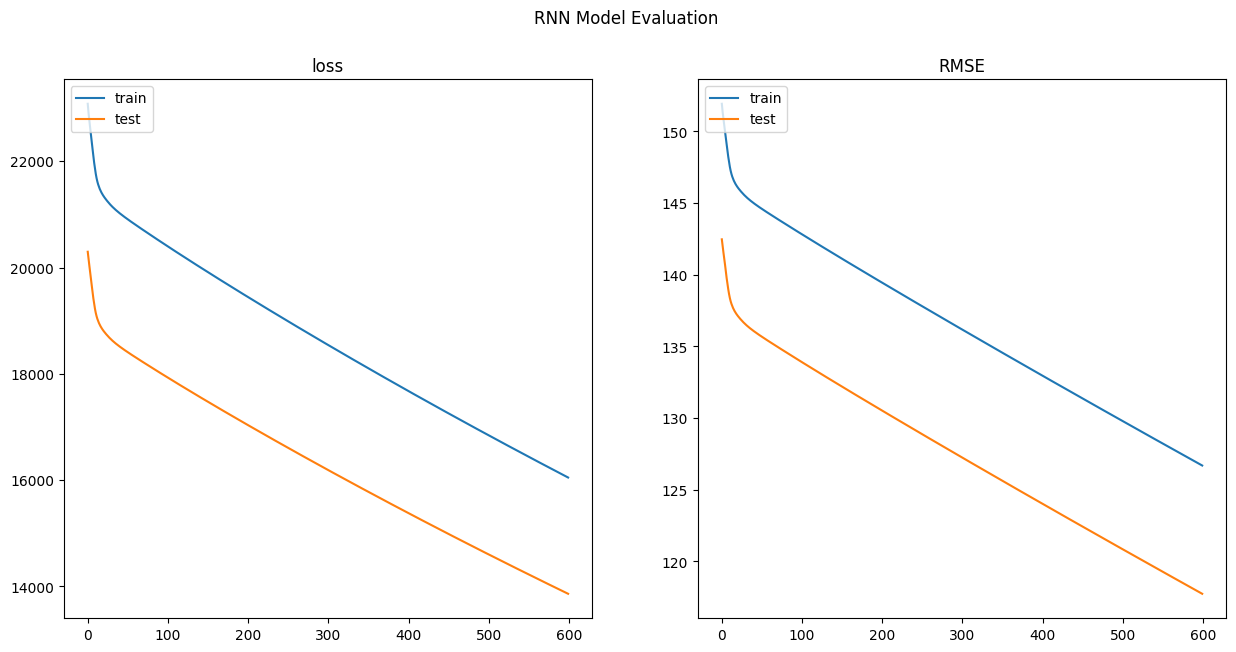

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [28]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  

mean_squared_error(y_test, y_pred)**0.5

1/1 [==============================] - 3s 3s/step


117.74098255755273

**LSTM with one layer**

In [29]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        LSTM(32, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 


2023-04-23 14:36:51.505823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:36:51.522715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:36:51.530276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600


2023-04-23 14:37:21.785327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:37:21.953390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:37:21.970852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s - loss: 23152.7090 - root_mean_squared_error: 152.1601

2023-04-23 14:37:31.762160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:37:31.767218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:37:31.770978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 12s 12s/step - loss: 23152.7090 - root_mean_squared_error: 152.1601 - val_loss: 20515.3672 - val_root_mean_squared_error: 143.2319
Epoch 2/600
1/1 [==============================] - 0s 156ms/step - loss: 23140.3535 - root_mean_squared_error: 152.1195 - val_loss: 20507.5254 - val_root_mean_squared_error: 143.2045
Epoch 3/600
1/1 [==============================] - 0s 124ms/step - loss: 23132.1621 - root_mean_squared_error: 152.0926 - val_loss: 20499.1543 - val_root_mean_squared_error: 143.1753
Epoch 4/600
1/1 [==============================] - 0s 135ms/step - loss: 23123.4141 - root_mean_squared_error: 152.0638 - val_loss: 20490.1816 - val_root_mean_squared_error: 143.1439
Epoch 5/600
1/1 [==============================] - 0s 141ms/step - loss: 23114.0137 - root_mean_squared_error: 152.0329 - val_loss: 20480.6016 - val_root_mean_squared_error: 143.1105
Epoch 6/600
1/1 [==============================] - 0s 134ms/step - loss: 23103.9531 - root_mean_sq

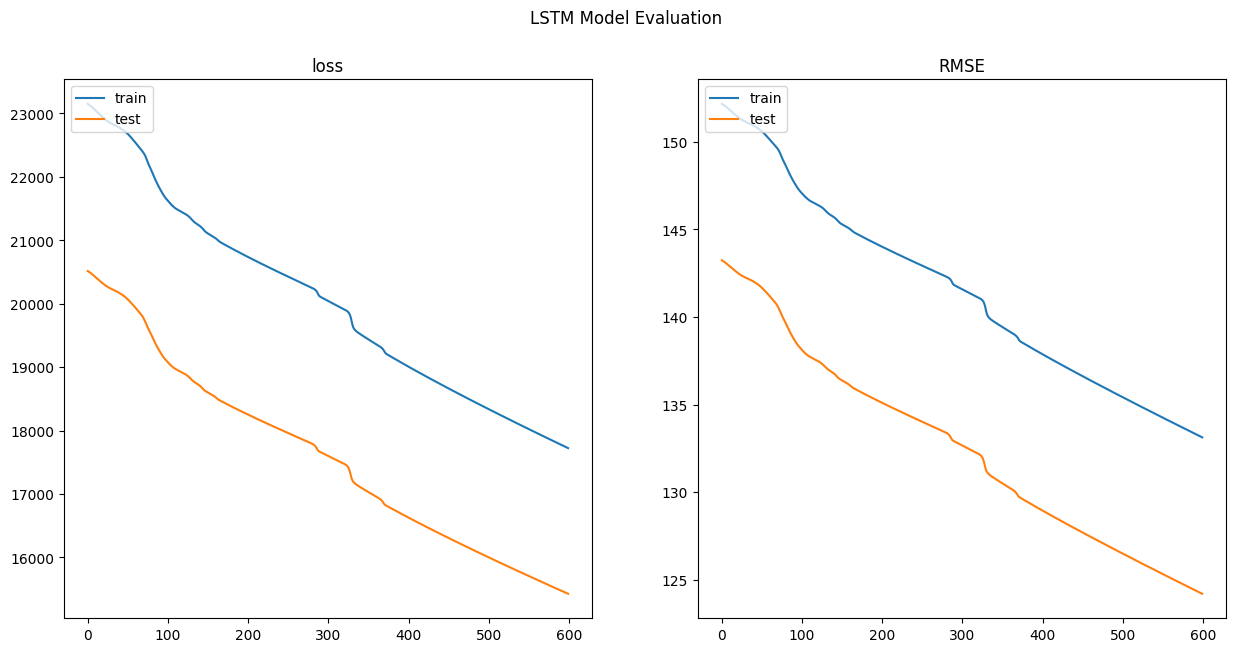

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('LSTM Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [33]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  
mean_squared_error(y_test, y_pred)**0.5


2023-04-23 14:39:44.475142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:39:44.489475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:39:44.497139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step


124.20450109088132

**LSTM with more layers**

In [34]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        LSTM(75,return_sequences=True, input_shape=[n_steps, n_inputs]),
        LSTM(64, return_sequences=True),
        LSTM(32,return_sequences=False),
        Dense(1, activation=None)
    ]
)
model.summary()

2023-04-23 14:39:58.300386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:39:58.307513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:39:58.312537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 9, 75)             23100     
                                                                 
 lstm_2 (LSTM)               (None, 9, 64)             35840     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 71,389
Trainable params: 71,389
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600


2023-04-23 14:40:13.086577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:40:13.173788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:40:13.178677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s - loss: 23283.8984 - root_mean_squared_error: 152.5906

2023-04-23 14:40:36.501617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:40:36.509831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:40:36.513854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 28s 28s/step - loss: 23283.8984 - root_mean_squared_error: 152.5906 - val_loss: 20632.4023 - val_root_mean_squared_error: 143.6398
Epoch 2/600
1/1 [==============================] - 0s 151ms/step - loss: 23259.3008 - root_mean_squared_error: 152.5100 - val_loss: 20609.1426 - val_root_mean_squared_error: 143.5589
Epoch 3/600
1/1 [==============================] - 0s 168ms/step - loss: 23234.7930 - root_mean_squared_error: 152.4296 - val_loss: 20583.7852 - val_root_mean_squared_error: 143.4705
Epoch 4/600
1/1 [==============================] - 0s 144ms/step - loss: 23208.0488 - root_mean_squared_error: 152.3419 - val_loss: 20555.5156 - val_root_mean_squared_error: 143.3719
Epoch 5/600
1/1 [==============================] - 0s 148ms/step - loss: 23178.2227 - root_mean_squared_error: 152.2440 - val_loss: 20523.3594 - val_root_mean_squared_error: 143.2598
Epoch 6/600
1/1 [==============================] - 0s 165ms/step - loss: 23144.2559 - root_mean_sq

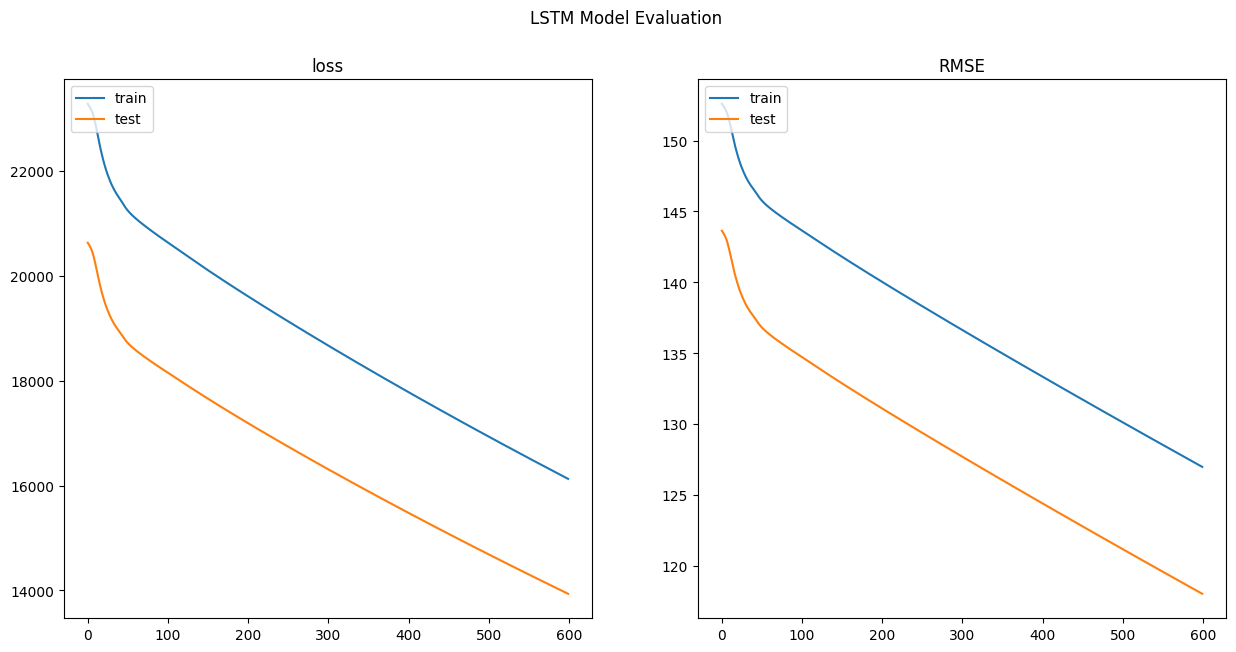

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('LSTM Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [38]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  

mean_squared_error(y_test, y_pred)**0.5


2023-04-23 14:42:54.817245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:42:54.824300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:42:54.827844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 6s 6s/step


118.05112008632382

**GRU with one layer**

In [39]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        GRU(32, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 


2023-04-23 14:43:11.194037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:43:11.200754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:43:11.208229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600


2023-04-23 14:43:20.529460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:43:20.535768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:43:20.545586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s - loss: 23331.9863 - root_mean_squared_error: 152.7481

2023-04-23 14:43:32.923442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:43:32.935192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:43:32.941650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 15s 15s/step - loss: 23331.9863 - root_mean_squared_error: 152.7481 - val_loss: 20689.1914 - val_root_mean_squared_error: 143.8374
Epoch 2/600
1/1 [==============================] - 0s 124ms/step - loss: 23324.0000 - root_mean_squared_error: 152.7220 - val_loss: 20682.9707 - val_root_mean_squared_error: 143.8158
Epoch 3/600
1/1 [==============================] - 0s 147ms/step - loss: 23317.6562 - root_mean_squared_error: 152.7012 - val_loss: 20676.1465 - val_root_mean_squared_error: 143.7920
Epoch 4/600
1/1 [==============================] - 0s 248ms/step - loss: 23310.7051 - root_mean_squared_error: 152.6784 - val_loss: 20668.5137 - val_root_mean_squared_error: 143.7655
Epoch 5/600
1/1 [==============================] - 0s 291ms/step - loss: 23302.9219 - root_mean_squared_error: 152.6529 - val_loss: 20659.8594 - val_root_mean_squared_error: 143.7354
Epoch 6/600
1/1 [==============================] - 0s 233ms/step - loss: 23294.0527 - root_mean_sq

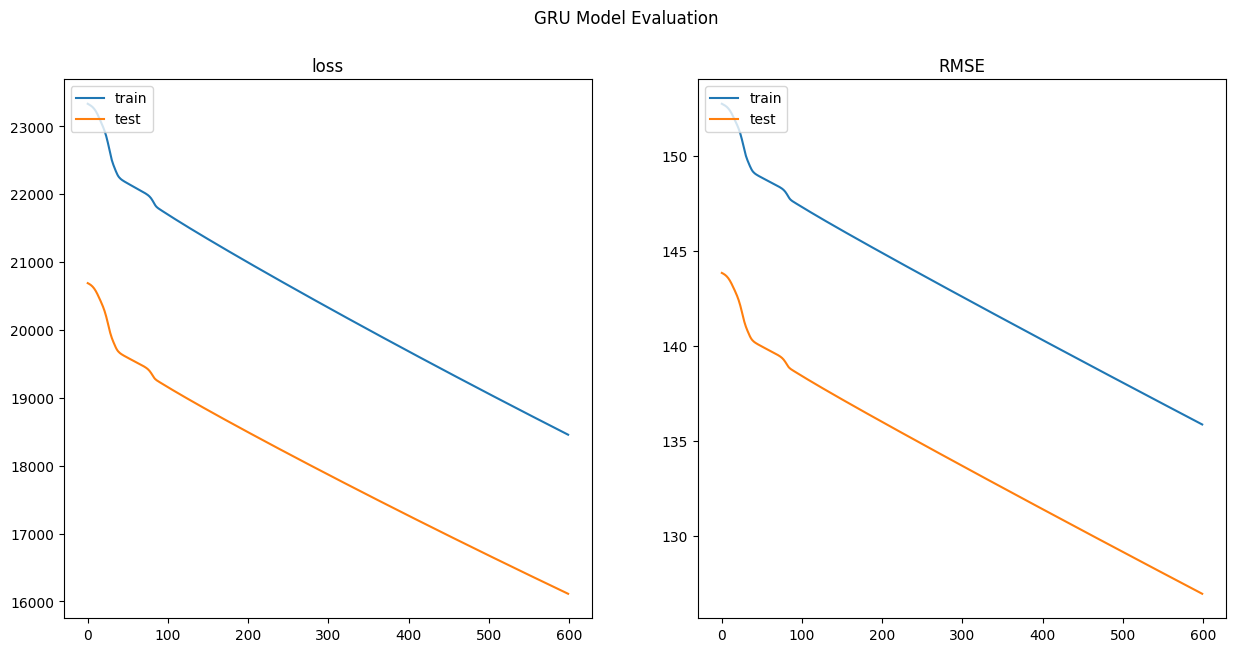

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [43]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  

mean_squared_error(y_test, y_pred)**0.5


2023-04-23 14:46:37.445783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:46:37.452260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:46:37.456331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step


126.93424415327164

**GRU with more layers**

In [44]:
n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        GRU(75,return_sequences=True, input_shape=[n_steps, n_inputs]),
        GRU(64, return_sequences=True),
        GRU(32,return_sequences=False),
        Dense(1, activation=None)
    ]
)
model.summary()

2023-04-23 14:47:05.826544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:47:05.837668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:47:05.842889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2023-04-23 14:47:08.526468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:47:08.533365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:47:08.544337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 gru_1 (GRU)                 (None, 9, 75)             17550     
                                                                 
 gru_2 (GRU)                 (None, 9, 64)             27072     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 54,063
Trainable params: 54,063
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600


2023-04-23 14:47:20.367024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:47:20.373914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:47:20.380023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s - loss: 23471.9004 - root_mean_squared_error: 153.2054

2023-04-23 14:47:48.430356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:47:48.437670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:47:48.465772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 33s 33s/step - loss: 23471.9004 - root_mean_squared_error: 153.2054 - val_loss: 20747.7812 - val_root_mean_squared_error: 144.0409
Epoch 2/600
1/1 [==============================] - 0s 235ms/step - loss: 23381.6426 - root_mean_squared_error: 152.9106 - val_loss: 20662.0078 - val_root_mean_squared_error: 143.7429
Epoch 3/600
1/1 [==============================] - 0s 145ms/step - loss: 23290.9629 - root_mean_squared_error: 152.6138 - val_loss: 20571.5723 - val_root_mean_squared_error: 143.4279
Epoch 4/600
1/1 [==============================] - 0s 160ms/step - loss: 23195.3164 - root_mean_squared_error: 152.3001 - val_loss: 20476.1250 - val_root_mean_squared_error: 143.0948
Epoch 5/600
1/1 [==============================] - 0s 150ms/step - loss: 23094.3320 - root_mean_squared_error: 151.9682 - val_loss: 20375.9316 - val_root_mean_squared_error: 142.7443
Epoch 6/600
1/1 [==============================] - 0s 157ms/step - loss: 22988.2910 - root_mean_sq

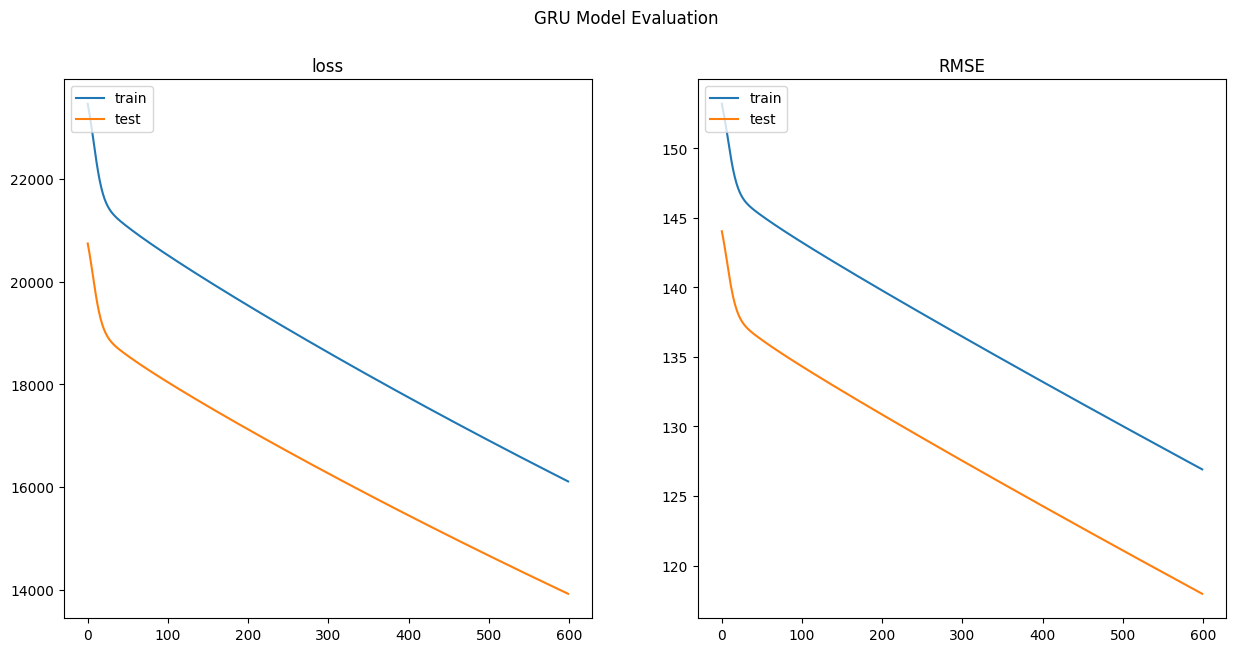

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [48]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test) 

mean_squared_error(y_test, y_pred)**0.5


2023-04-23 14:50:06.662971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:50:06.670836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:50:06.738950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 7s 7s/step


117.97163112171133

**Conv1D**

In [49]:
n_steps = sequence_length-1
n_inputs = 1

model = Sequential([
    Conv1D(filters=10, kernel_size=3, strides=1, padding="valid", input_shape=[n_steps, n_inputs]),
    Conv1D(filters=20, kernel_size=3, strides=1, padding="valid"),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation=None)
])

model.summary()

2023-04-23 14:50:18.719811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:50:18.873265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:50:18.885215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"


2023-04-23 14:50:20.603166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:50:20.609748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:50:20.619782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 10)             40        
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 20)             620       
                                                                 
 lstm_4 (LSTM)               (None, 5, 64)             21760     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,869
Trainable params: 34,869
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600


2023-04-23 14:50:32.446288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:50:32.453369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:50:32.460275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s - loss: 23010.3418 - root_mean_squared_error: 151.6916

2023-04-23 14:50:53.056193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:50:53.062602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:50:53.068267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 25s 25s/step - loss: 23010.3418 - root_mean_squared_error: 151.6916 - val_loss: 20359.4961 - val_root_mean_squared_error: 142.6867
Epoch 2/600
1/1 [==============================] - 0s 415ms/step - loss: 22969.3672 - root_mean_squared_error: 151.5565 - val_loss: 20321.6016 - val_root_mean_squared_error: 142.5538
Epoch 3/600
1/1 [==============================] - 0s 233ms/step - loss: 22929.0137 - root_mean_squared_error: 151.4233 - val_loss: 20283.1367 - val_root_mean_squared_error: 142.4189
Epoch 4/600
1/1 [==============================] - 0s 171ms/step - loss: 22889.0527 - root_mean_squared_error: 151.2913 - val_loss: 20235.0273 - val_root_mean_squared_error: 142.2499
Epoch 5/600
1/1 [==============================] - 0s 153ms/step - loss: 22839.5859 - root_mean_squared_error: 151.1277 - val_loss: 20176.3867 - val_root_mean_squared_error: 142.0436
Epoch 6/600
1/1 [==============================] - 0s 166ms/step - loss: 22776.0176 - root_mean_sq

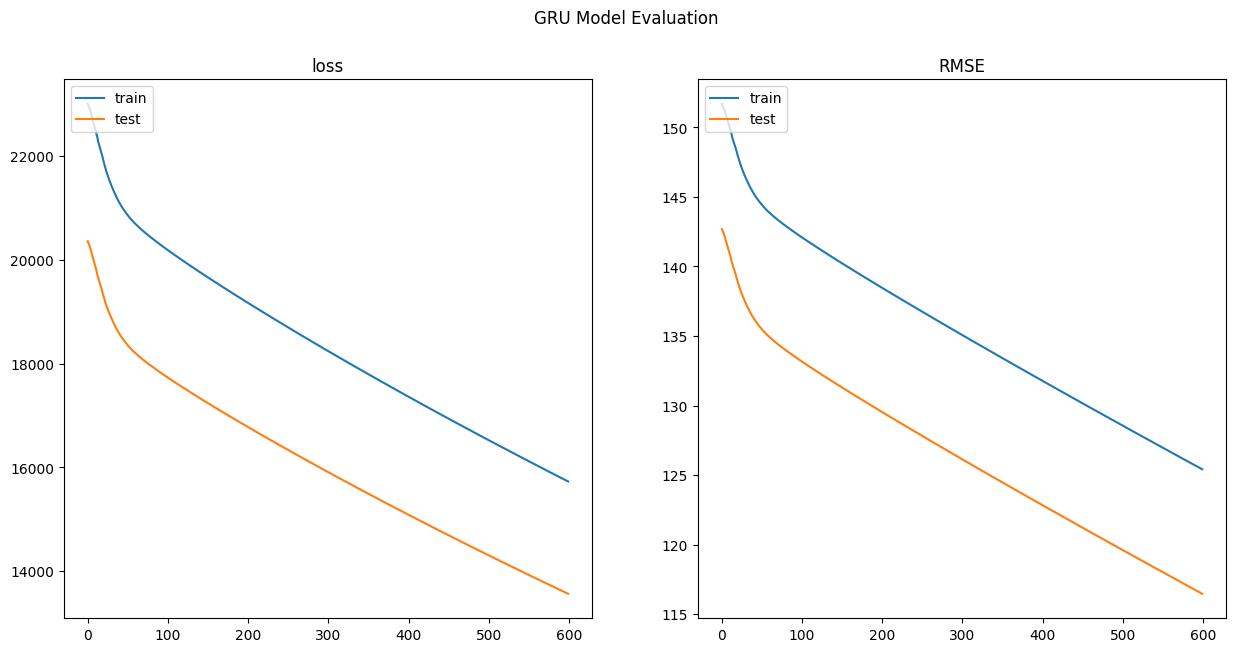

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [53]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test) 

mean_squared_error(y_test, y_pred)**0.5


2023-04-23 14:53:39.191117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:53:39.196639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:53:39.204338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step


116.4706737005976

CONV1D has performed better in predicting the 10th-day closing price. Considering MeanSqr error as metric to measure, the CONV1D performed the best out of all with least MeanSqr error of 116.47. Next, GRU Multi layer and Deep RNN performed similarly. This followed by LSTM with multi layer and LSTM single layer and GRU with single layer with the highest Meansqr Error.